In [15]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

from matplotlib import cm
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from statsmodels.distributions.empirical_distribution import ECDF
from itertools import product

from ffc_utils import _fknn_forecast_dynamic_update

from functional_utils import _confidence_intervals_from_eCDF

from scores_utils import (_empirical_coverage_score,
                          _weighted_empirical_interval_score)

from loading_utils import (_process_wind_metadata,
                           _process_testing_curves,
                           _process_testing_forecasts,
                           _process_training_curves,
                           _process_traning_forecasts)

from scores_utils import *

plt.rcParams["legend.handlelength"] = 1
plt.rcParams["legend.handleheight"] = 1.125
plt.rcParams["font.family"]         = "Avenir"

path_to_fDepth     = '/home/gterren/dynamic_update/functional_forecast_dynamic_update/fDepth'
path_to_data       = '/home/gterren/dynamic_update/data'
path_to_validation = '/home/gterren/dynamic_update/validation'
path_to_test       = '/home/gterren/dynamic_update/test'
path_to_images     = '/home/gterren/dynamic_update/imapges'

# Loading color palette
palette_ = pd.read_csv(path_to_data + "/palette.csv")

# Loading Texas map
TX_ = gpd.read_file(path_to_data + "/maps/TX/State.shp")

In [9]:
# Timestamps in interval
T = 288

# Loading and processing of sites metadata
meta_ = _process_wind_metadata(file_name = '/wind_meta.xlsx', 
                               path      = path_to_data)
assets_ = meta_.index
X_tr_   = meta_[['lon', 'lat']].to_numpy()
print(X_tr_.shape)

meta_      = meta_.reset_index(drop = False)
vals, idx_ = np.unique(X_tr_, return_index = True, axis = 0)
assets_    = assets_[idx_]
X_tr_      = X_tr_[idx_, :]
print(assets_.shape)

idx_       = np.argsort(assets_)
assets_    = assets_[idx_]
X_tr_      = X_tr_[idx_, :]
print(assets_.shape)

# Loading and processing of historical curves for the training dataset
F_tr_, T_tr_, x_tr_, p_ = _process_training_curves(X_tr_, assets_, T,
                                                   file_name = '/actuals/wind_actual_5min_site_2017.csv',
                                                   path      = path_to_data)
print(F_tr_.shape, T_tr_.shape, x_tr_.shape, p_.shape)

# Loading and processing of historical curves for the testing dataset
F_ts_, T_ts_, x_ts_ = _process_testing_curves(X_tr_, assets_, p_, T,
                                              file_name = '/actuals/wind_actual_5min_site_2018.csv',
                                              path      = path_to_data)
print(F_ts_.shape, T_ts_.shape, x_ts_.shape)

# Loading and processing of historical day-ahead forecast for the training dataset
E_tr_ = _process_traning_forecasts(assets_, p_, T, 
                                   file_name = '/actuals/wind_day_ahead_forecast_2017.csv',
                                   path      = path_to_data)
print(E_tr_.shape)

# Loading and processing of historical day-ahead forecast for the testing dataset
E_ts_ = _process_testing_forecasts(assets_, p_, T,
                                   file_name = '/actuals/wind_day_ahead_forecast_2018.csv', 
                                   path      = path_to_data)
print(E_ts_.shape)

dt_ = np.array([t*5 for t in range(T)])
dx_ = pd.to_datetime(pd.DataFrame({'time': dt_}).time, unit = 'm').dt.strftime('%H:%M').to_numpy()
print(dt_.shape, dx_.shape)

t_tr_ = np.array([datetime.datetime.strptime(t_tr, '%Y-%m-%d').timetuple().tm_yday for t_tr in T_tr_]) - 1
t_ts_ = np.array([datetime.datetime.strptime(t_ts, '%Y-%m-%d').timetuple().tm_yday for t_ts in T_ts_])
print(t_tr_.shape, t_ts_.shape)

(264, 2)
(187,)
(187,)
(67881, 288) (67881,) (67881, 2) (187,)
(363, 288, 187) (363,) (187, 2)
(67881, 288)
(365, 288, 187)
(288,) (288,)
(67881,) (363,)


In [18]:
# Significance levels for the confidence intervals
alpha_ = [0.1, 0.2, 0.3, 0.4]

# Hyperparameters for the functional forecast dynamic update
forget_rate_f_  = [.25]
forget_rate_e_  = [.125]
length_scale_f_ = [0.003]   
length_scale_e_ = [0.1]
lookup_rate_    = [64]
trust_rate_     = [16]
nu_             = [6]
gamma_          = [100]
xi_             = [0.5]
kappa_min_      = [500]
kappa_max_      = [1500]

params_ = tuple(product(forget_rate_f_, 
                        forget_rate_e_, 
                        length_scale_f_,
                        length_scale_e_,
                        lookup_rate_, 
                        trust_rate_, 
                        nu_,
                        gamma_,
                        xi_, 
                        kappa_min_, 
                        kappa_max_))[0]
print(params_)

asset = 30
day   = 3
time  = 144

file_name = f'{asset}-{day}-{time}'
print(file_name)

t1 = datetime.datetime.now()


f_     = F_ts_[day, :time, asset]
e_     = E_ts_[day, :, asset]
x_     = x_ts_[asset, :]
t      = t_ts_[day]
f_hat_ = F_ts_[day, time:, asset]

# Get time constants
tau_ = dt_[:time]
s_   = dt_[time:]

_model, M_ = _fknn_forecast_dynamic_update(F_tr_, E_tr_, x_tr_, t_tr_, dt_, f_, e_, x_, t,
                                           forget_rate_f  = params_[0],
                                           forget_rate_e  = params_[1],
                                           length_scale_f = params_[2],
                                           length_scale_e = params_[3],
                                           lookup_rate    = params_[4],
                                           trust_rate     = params_[5],
                                           nu             = params_[6],
                                           gamma          = params_[7],
                                           xi             = params_[8],
                                           kappa_min      = params_[9],
                                           kappa_max      = params_[10])

f_tau_rmse = np.sqrt(np.mean((f_ - e_[:time])**2))
f_s_rmse   = np.sqrt(np.mean((np.median(M_, axis = 0) - e_[time:])**2))
print(f_tau_rmse, f_s_rmse)

# Calculate marginal empirical confidence intervals
m_, _upper, _lower = _confidence_intervals_from_eCDF(M_, alpha_)

WIS_f = np.mean(_weighted_empirical_interval_score(f_hat_, 
                                                    m_, 
                                                    _lower, 
                                                    _upper, 
                                                    alpha_))

WIS_e = np.mean(_weighted_empirical_interval_score(e_[time:], 
                                                    m_, 
                                                    _lower, 
                                                    _upper, 
                                                    alpha_))
print(WIS_f, WIS_e)

t2 = datetime.datetime.now()
print(t2 - t1)

print(assets_[asset], T_ts_[day])

(0.25, 0.125, 0.003, 0.1, 64, 16, 6, 100, 0.5, 500, 1500)
30-3-144
0.14651519536680965 0.1195899106326977
0.05805455206571349 0.06957242580470203
0:00:00.463891
Bull Creek Wind Farm 2018-01-05


NameError: name 'sns' is not defined

findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not

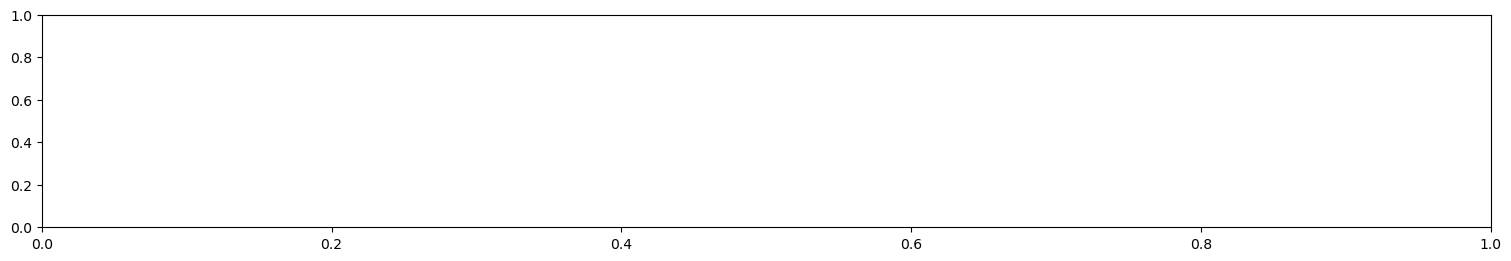

In [ ]:
def _plot_density_heatmap(_ax, M_, f_, e_, f_hat_, dx_, dt_, t):

    tau_ = dt_[:t]
    s_ = dt_[t:]

    Z_ = []
    for i in range(M_.shape[1]):
        a_, b_ = np.histogram(100.0 * M_[:, i], 
                              bins=25, 
                              range=(0, 100), 
                              density=True)
        Z_.append(a_)

    Z_ = np.stack(Z_).T
    X_, Y_ = np.meshgrid(dt_[t:], (b_[1:] + b_[:-1]) / 2.0)

    _cmap = sns.color_palette("rocket_r", as_cmap=True)
    _ax.pcolormesh(X_, Y_, Z_, cmap =_cmap)

    _ax.plot(dt_, 100 * e_, 
             c="k", 
             lw=2.0, 
             label="CF (fc)", 
             clip_on=False)

    _ax.plot(tau_, 100 * f_,
             c=palette_.loc[0, "ibm"],
             clip_on=False,
             lw=2.0,
             label="CF (ac)")

    _ax.plot(s_, 100 * f_hat_, 
             c=palette_.loc[0, "ibm"], 
             clip_on=False, 
             lw=2.0, 
             ls="--")

    _ax.fill_between(tau_, 100 * np.ones(tau_.shape), 100 * np.zeros(tau_.shape),
                     color="lightgray",
                     alpha=0.375)

    _ax.axvline(dt_[t - 1], 
                color="k", 
                linewidth=0.75, 
                label="Event (update)")

    _ax.axvline(dt_[t], 
                color="k", 
                lw=0.75, 
                ls="--", 
                label="Detail")

    _ax.set_xticks(dt_[::12], dx_[::12], rotation=45)
    _ax.set_ylabel("Capacity Factor (%)", size=14)

    _ax.tick_params(axis="both", labelsize=14)

    _ax.set_ylim(0.0, 100.0)
    _ax.set_xlim(dt_[0], dt_[-1])

    _ax.legend(frameon=False, 
               fontsize=14, 
               ncol=1)

    cbar = fig.colorbar(cm.ScalarMappable(cmap=_cmap),
                        cax=_ax.inset_axes([180, 75, 100, 7.5], transform=_ax.transData),
                        orientation="horizontal",
                        extend="max")

    cbar.set_ticks([0, 1], labels=["low", "high"], fontsize = 14)
    cbar.ax.tick_params(length=0)

    cbar.ax.set_title("EDF", rotation=0)

fig, _ax = plt.subplots(1, 1, 
                        figsize=(15, 2.5), 
                        layout="constrained")

_plot_density_heatmap(_ax, M_, f_, e_, f_hat_, dx_, dt_, t, cuts_)

plt.savefig(path_to_images + f"/EDF_heatmap_{file_name}.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

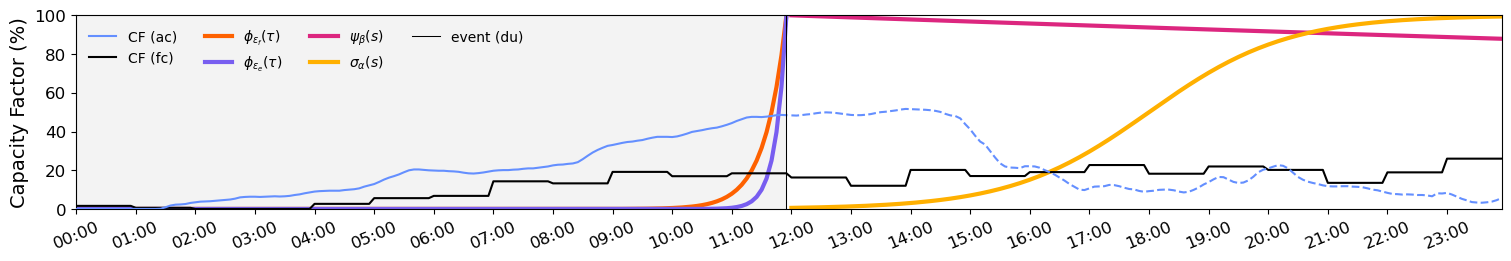

In [8]:
_fig, _ax = plt.subplots(1, 1, 
                         figsize = (15, 2.5), 
                         layout = "constrained")

_plot_forecast_parameters(_ax, 
                          palette_, 
                          f_, 
                          e_, 
                          f_hat_, 
                          _model['phi'], 
                          _model['psi'], 
                          _model['eta'], 
                          dx_, 
                          dt_, 
                          time)

plt.savefig(path_to_images + r"/kNN_hyperparameters.pdf", 
            bbox_inches = "tight", 
            dpi = 600)

plt.show()

KeyError: 'a'

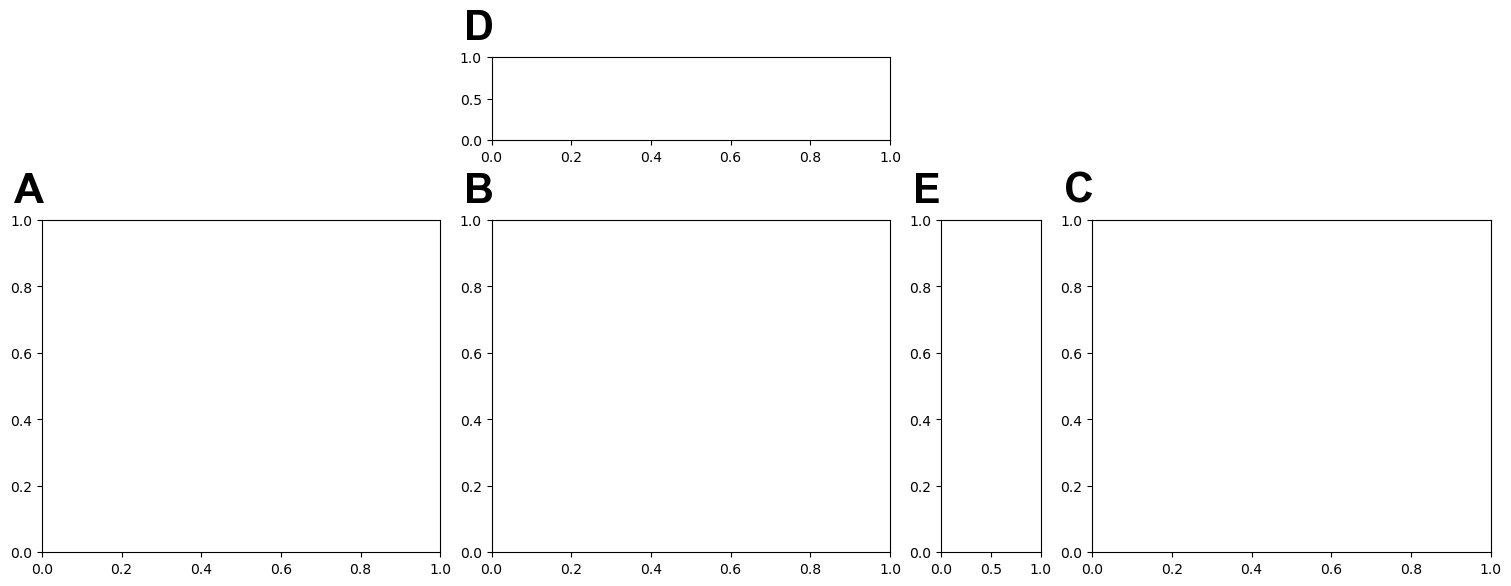

In [9]:
def _plot_fneighborhood(_ax, palette_, d_f_, d_e_, w_f_, w_e_, w_, idx_0_, idx_1_, idx_2_, xi):

    _ax["a"].plot(d_f_[np.argsort(d_f_)], w_f_[np.argsort(d_f_)],
                  c=palette_.loc[0, "ibm"],
                  lw=2.5,
                  label="f")

    _ax["a"].plot(d_e_[np.argsort(d_e_)], w_e_[np.argsort(d_e_)],
                  c=palette_.loc[3, "ibm"],
                  lw=2.5,
                  label="e")

    _ax["a"].axhline(xi, 
                     ls="--", 
                     color="k", 
                     lw=1.0, 
                     label=r"$\xi$", 
                     zorder=10)

    _ax["a"].set_ylabel(r"$\varphi_{\lambda} (r)$", size=14)
    _ax["a"].set_xlabel(r"$r$", size=14)

    _ax["a"].tick_params(axis="both", 
                         labelsize=12)
    
    _ax["a"].legend(frameon=False, 
                    fontsize=12)
    
    _ax["a"].set_xlim(0, 1)
    _ax["a"].set_ylim(0, 1)

    _ax["e"].scatter(w_f_, w_e_, 
                     c="gray", 
                     s=35, 
                     alpha=1.0, 
                     lw=0.25, 
                     ec="k", 
                     label="Scen.")

    _ax["e"].scatter(w_f_[idx_1_], w_e_[idx_1_],
                     c=palette_.loc[0, "ibm"],
                     s=35,
                     alpha=1.0,
                     lw=0.25,
                     ec="k",
                     label="Neighbors")

    c_ = [palette_.loc[2, "ibm"], palette_.loc[4, "ibm"]]
    # for i, j in zip(idx_2_, idx_0_[idx_2_]):
    _ax["e"].scatter(w_f_[idx_2_], w_e_[idx_2_],
                     c=palette_.loc[3, "ibm"],
                     s=35,
                     lw=0.25,
                     ec="k",
                     alpha=1.0,
                     label="Filtered-out")

    _ax["e"].axline((1, 1), 
                    slope=1, 
                    lw=1, 
                    c="k")

    _ax["e"].set_ylabel(r"$\varphi_{\lambda_e} (r_{e})$", size=14)
    _ax["e"].set_xlabel(r"$\varphi_{\lambda_f} (r_{f})$", size=14)

    _ax["e"].tick_params(axis="both", 
                         labelsize=12)

    _ax["e"].set_xlim(w_f_[idx_2_].min() * 0.9985, w_f_[idx_2_].max() * 1.0015)
    _ax["e"].set_ylim(w_e_[idx_2_].min() * 0.9985, w_e_[idx_2_].max() * 1.0015)

    _ax["e"].axhline(xi, 
                     ls="--", 
                     color="k", 
                     lw=1.0, 
                     zorder=10)
    
    _ax["e"].axvline(xi, 
                     ls="--", 
                     color="k", 
                     lw=1.0, 
                     zorder=10)

    _ax["e"].legend(frameon=False, 
                    fontsize=12, 
                    ncol=3)

    _ax["c"].tick_params(axis="x", 
                         labelbottom=False)
    
    _ax["d"].tick_params(axis="y", 
                         labelleft=False)

    _ax["b"].scatter(w_f_, w_e_, 
                     color="gray", 
                     s=0.25, 
                     zorder=1)

    _ax["b"].scatter(w_f_[idx_1_], w_e_[idx_1_], 
                     c=palette_.loc[0, "ibm"], 
                     s=0.25, 
                     zorder=2)

    _ax["b"].axhline(xi, 
                     ls="--", 
                     color="k", 
                     lw=1.0, 
                     label=r"$\xi$", 
                     zorder=10)

    _ax["b"].axvline(xi, 
                     ls="--", 
                     color="k", 
                     lw=1.0, 
                     label=r"$\xi$", 
                     zorder=10)

    _ax["b"].set_ylabel(r"$\varphi_{\lambda_e} (r_{e})$", size=14)
    _ax["b"].set_xlabel(r"$\varphi_{\lambda_f} (r_{f})$", size=14)

    _ax["b"].tick_params(axis="both", 
                         labelsize=12)
    _ax["b"].set_xlim(0, 1)
    _ax["b"].set_ylim(0, 1)

    _ax["c"].hist(w_f_, 
                  bins=50, 
                  color="gray", 
                  density=True)

    _ax["c"].tick_params(axis="both", 
                         labelsize=12)


    _ax["c"].set_xlim(0, 1)

    _ax["d"].hist(w_e_, 
                  bins=50, 
                  color="gray", 
                  density=True, 
                  orientation="horizontal")

    _ax["d"].tick_params(axis="both", 
                         labelsize=12)
    
    _ax["d"].set_ylim(0, 1)

_fig, _ax = plt.subplot_mosaic([[".", ".", "D", ".", ".", "."],
                                ["A", "A", "B", "E", "C", "C"],
                                ["A", "A", "B", "E", "C", "C"]],
                                figsize     = (15, 5.75),
                                layout      = "constrained",
                                gridspec_kw = dict(width_ratios  = (2, 2, 4, 1, 2, 2), 
                                                   height_ratios = (1, 2, 2)))
for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, _fig.dpi_scale_trans)),
            fontsize  = 30, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')
    
_plot_fneighborhood(_ax, 
                    palette_, 
                    _model['d_f'], 
                    _model['d_e'], 
                    _model['w_f'], 
                    _model['w_e'], 
                    _model['w'], 
                    _model['idx_1'], 
                    _model['idx_2'], 
                    _model['idx_3'], 
                    params_[8])

# plt.savefig(path_to_images + r"/fneighbor.png", 
#             bbox_inches="tight", 
#             dpi=300)

plt.show()

KeyError: 'gamma'

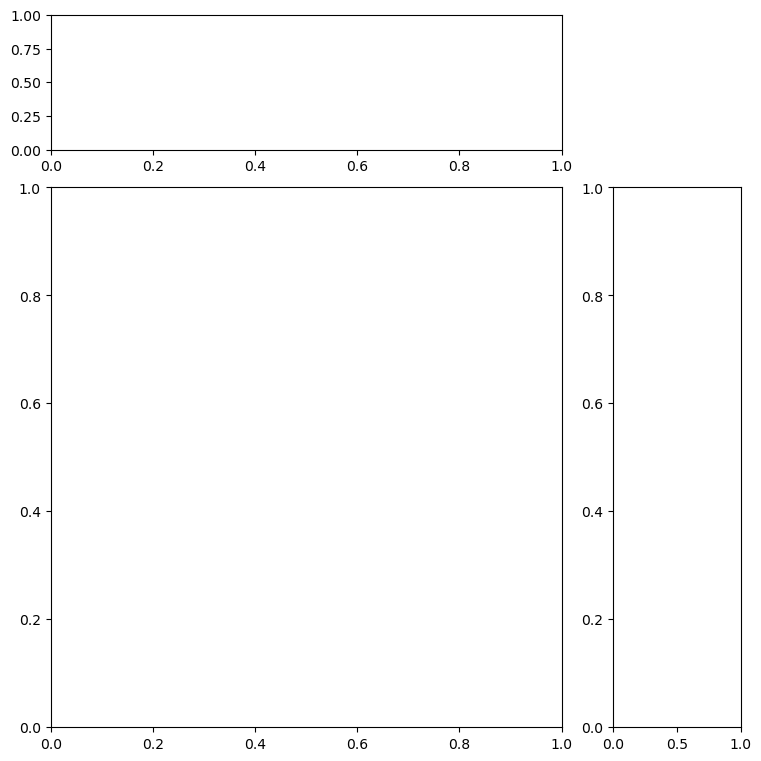

In [10]:
_fig, _ax = plt.subplot_mosaic([["B", "."], 
                                ["A", "C"]],
                                figsize     = (7.5, 7.5),
                                layout      = "constrained",
                                gridspec_kw = dict(width_ratios = (1, .25), 
                                                   height_ratios = (.25, 1)))

# for label, ax in _ax.items():
#     ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, _fig.dpi_scale_trans)),
#                              fontsize  = 24, 
#                              weight    = "bold",
#                              va        = 'bottom',
#                              family    = 'Arial')
    
_plot_dates_histogram(_ax["B"], 
                      palette_, 
                      t_tr_, 
                      _model['idx_1'], 
                      _model['idx_2'], 
                      t, 
                      _model['Gamma'], 
                      _model['gamma'])

_plot_scenario_filtering(_ax["A"], 
                         palette_, 
                         _model['d_h'], 
                         t_tr_, 
                         _model['idx_1'], 
                         _model['idx_3'], 
                         t, 
                         _model['Gamma'], 
                         _model['gamma'], 
                         _model['sigma'])

_plot_distance_histogram(_ax["C"], 
                         palette_, 
                         _model['d_h'], 
                         _model['idx_1'], 
                         _model['idx_3'])

_ax["A"].legend(frameon=False, 
                ncol=3, 
                loc = (0., 1.), 
                fontsize = 12)

plt.savefig(path_to_images + r"/kNN_frequency.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

(144,) (144,) (144,)


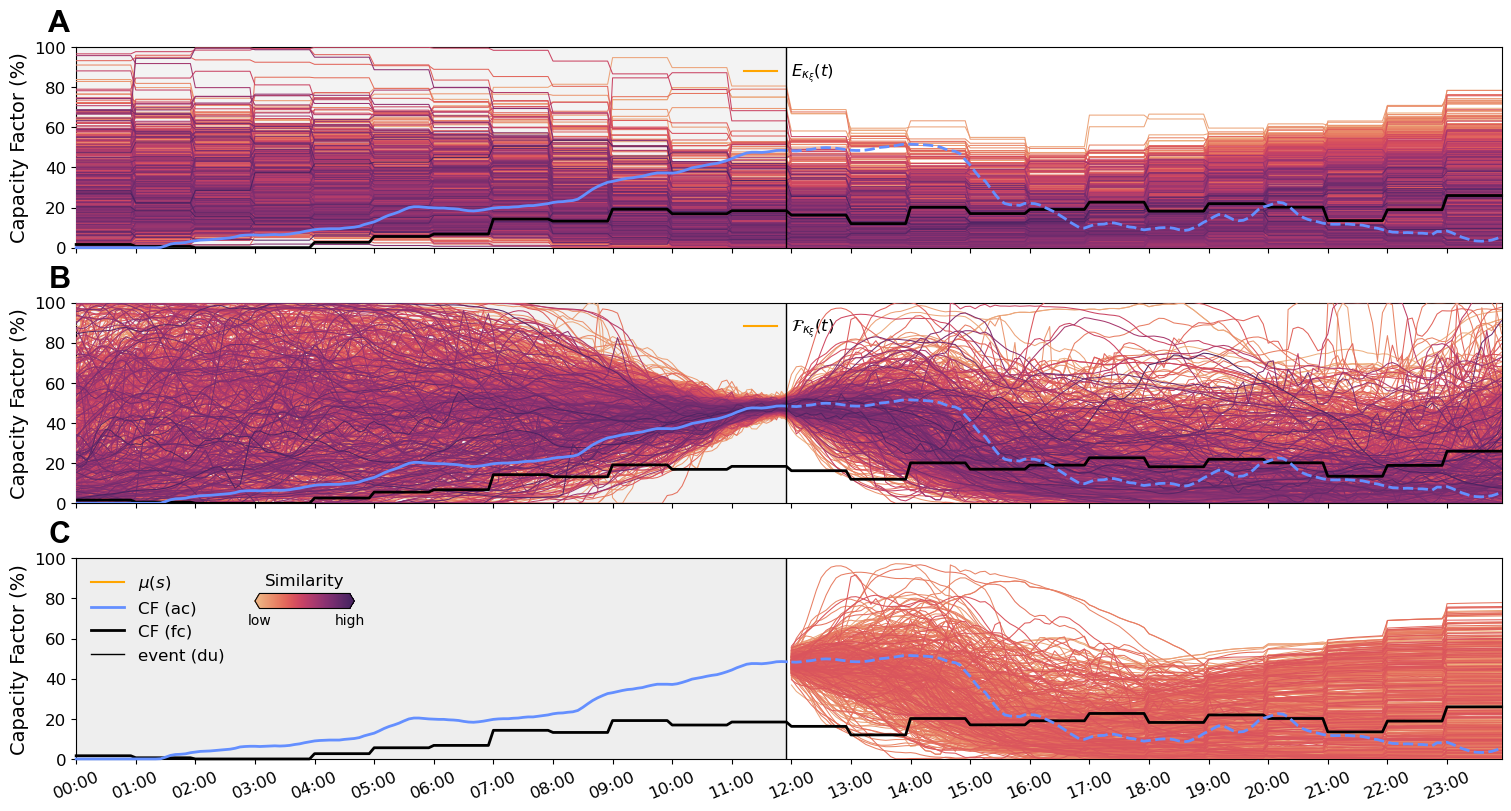

In [13]:
_fig, _ax = plt.subplot_mosaic([["A"], 
                                ["B"], 
                                ["C"]], 
                                figsize =(15, 8),
                                layout ="constrained", 
                                sharex = True)

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, _fig.dpi_scale_trans)),
            fontsize  = 22, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')
    
_plot_forecasts(_ax["A"], 
                palette_, 
                E_tr_, 
                f_, 
                e_, 
                f_hat_, 
                _model['w'], 
                _model['idx_2'], 
                dx_, 
                dt_, 
                time)

_plot_scenarios(_ax["B"], 
                palette_, 
                F_tr_, 
                f_, 
                e_, 
                f_hat_, 
                _model['w'], 
                _model['idx_2'], 
                dx_, 
                dt_, 
                time)

_plot_updates(_fig, 
              _ax["C"], 
              palette_, 
              M_, 
              f_, 
              e_, 
              f_hat_, 
              _model['w'], 
              _model['idx_2'], 
              dx_, 
              dt_, 
              time)

plt.savefig(path_to_images + r"/functional_neighbors.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

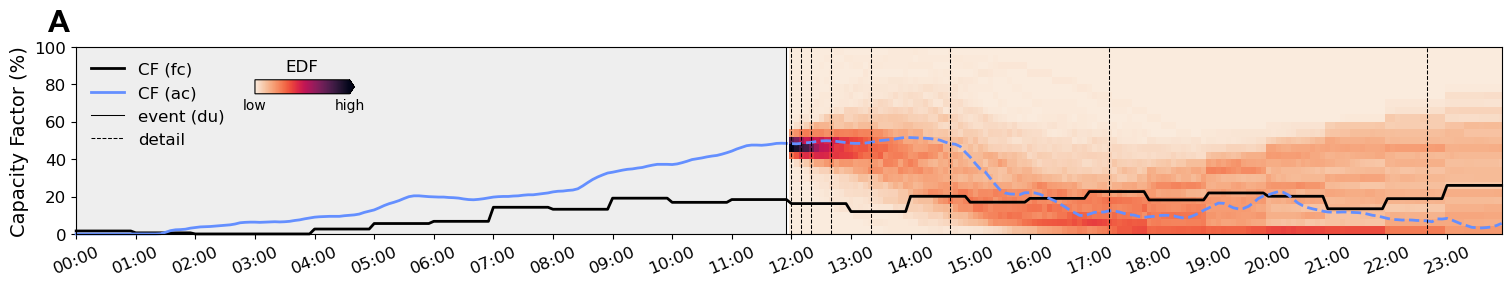

In [11]:
cuts_ = [2, 4, 8, 16, 32, 64, 128]

_fig, _ax = plt.subplot_mosaic([["A"]], 
                               figsize =(15, 2.75),
                               layout ="constrained", 
                               sharey = True)

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, _fig.dpi_scale_trans)),
            fontsize  = 22, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

_plot_density_heatmap(_fig, 
                      _ax['A'], 
                      palette_,
                      M_, 
                      f_, 
                      e_, 
                      f_hat_, 
                      dx_, 
                      dt_, 
                      time, 
                      cuts_)

plt.savefig(path_to_images + r"/kNN_heatmap.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

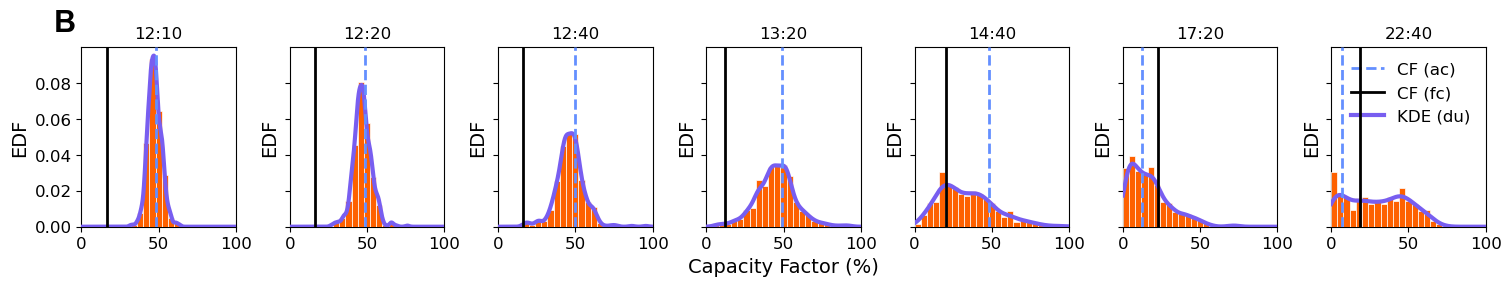

In [12]:
_fig, _ax = plt.subplot_mosaic([["B", "C", "D", "E", "F", "G", "H"]], 
                               figsize =(15, 2.75),
                               layout ="constrained", 
                               sharey = True)

for label, ax in _ax.items():
    if label == 'B':
        ax.text(0.0, 1.0, label, 
                transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, _fig.dpi_scale_trans)),
                fontsize  = 22, 
                weight    = "bold",
                va        = 'bottom',
                family    = 'Arial')
        
_plot_histogram_cuts( _ax['B'], 
                     palette_, 
                     M_, 
                     e_, 
                     f_hat_, 
                     dx_, dt_, 
                     time, 
                     cuts_[0])

_plot_histogram_cuts( _ax['C'], 
                     palette_, 
                     M_, 
                     e_, 
                     f_hat_, 
                     dx_, dt_, 
                     time, 
                     cuts_[1])

_plot_histogram_cuts( _ax['D'], 
                     palette_, 
                     M_, 
                     e_, 
                     f_hat_, 
                     dx_, dt_, 
                     time, 
                     cuts_[2])

_plot_histogram_cuts( _ax['E'], 
                     palette_, 
                     M_, 
                     e_, 
                     f_hat_, 
                     dx_, dt_, 
                     time, 
                     cuts_[3], xlabel = True)

_plot_histogram_cuts( _ax['F'], 
                     palette_, 
                     M_, 
                     e_, 
                     f_hat_, 
                     dx_, dt_, 
                     time, 
                     cuts_[4])

_plot_histogram_cuts( _ax['G'], 
                     palette_, 
                     M_, 
                     e_, 
                     f_hat_, 
                     dx_, dt_, 
                     time, 
                     cuts_[5])

_plot_histogram_cuts( _ax['H'], 
                     palette_, 
                     M_, 
                     e_, 
                     f_hat_, 
                     dx_, dt_, 
                     time, 
                     cuts_[6], legend = True)

plt.savefig(path_to_images + r"/kNN_desity.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

276.8717255781451
-101.584 32.9331


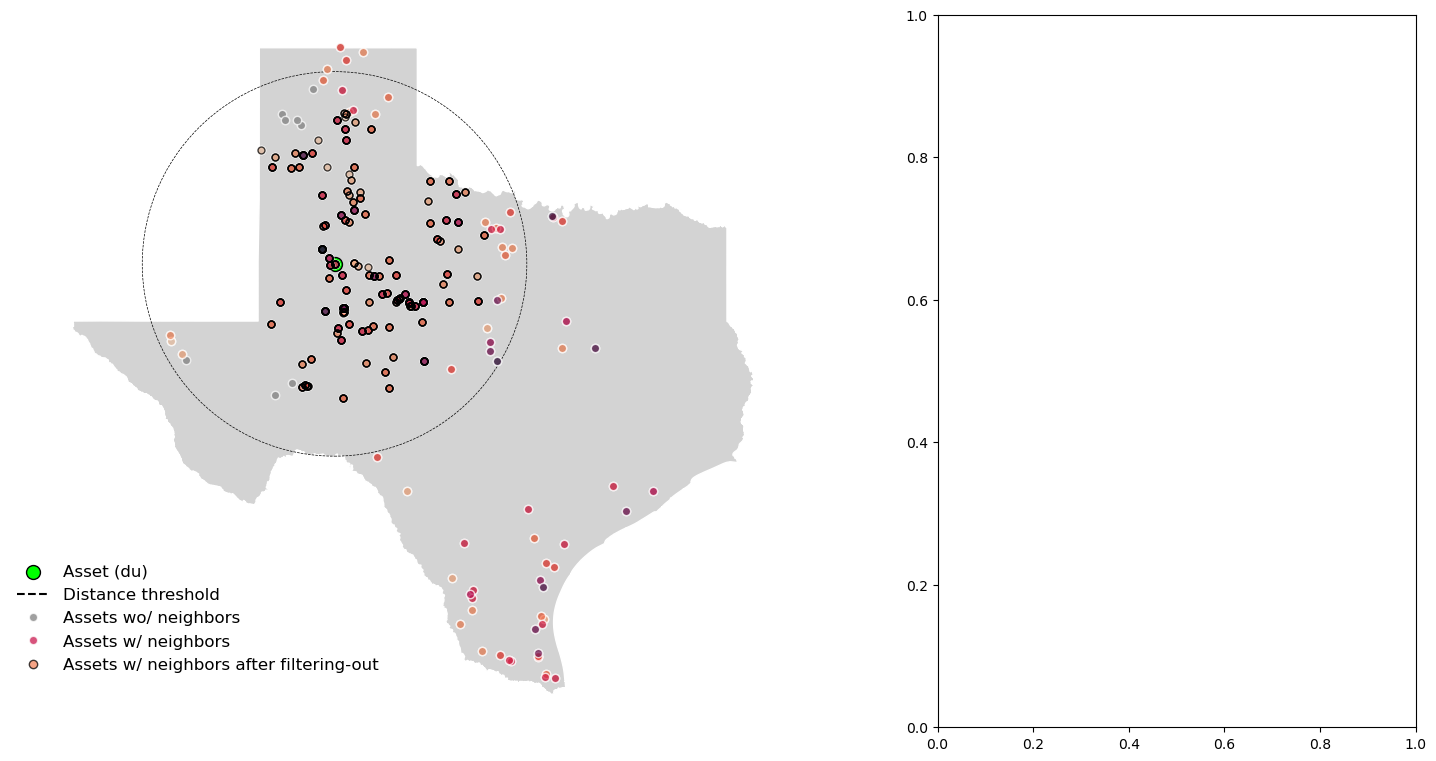

In [13]:
import seaborn as sns
from matplotlib import cm

def _plot_frequency_map(_fig, _ax, TX_, x_tr_, x_ts_, x_, idx_1_, idx_2_, sigma):

    x_tr_p_, z_tr_p_ = np.unique(x_tr_[idx_1_, :], 
                                 return_counts=True, 
                                 axis=0)

    _cmap = sns.color_palette("rocket_r", as_cmap=True)
    _norm = plt.Normalize(0.0, z_tr_p_.max())

    TX_.plot(ax=_ax, 
             facecolor="lightgray", 
             edgecolor="white", 
             zorder=0)

    _ax.scatter(x_[0], x_[1],
                c="lime",
                lw=1,
                ec="k",
                s=100.,
                zorder=1,
                marker="o",
                label="Asset (du)")

    if sigma != 0:
        print(sigma)
        print(x_[0], x_[1])
        _ax.scatter(x_[0], x_[1],
                    c="none",
                    lw=0.5,
                    ec="k",
                    ls = '--',
                    s=sigma**2,
                    zorder=1,
                    marker="o")

    _ax.plot(x_[0], x_[1],
             c="k",
             marker="None",
             ls="--",
             label="Distance threshold")
    
    _ax.plot(x_ts_[:, 0], x_ts_[:, 1],
             c="gray",
             alpha=0.75,
             ms=6,
             marker="o",
             mec="w",
             ls="none",
             mew=1.0,
             zorder=2,
             label="Assets wo/ neighbors")

    _ax.plot(x_[0], x_[1],
             c=_cmap(_norm(z_tr_p_.max() / 2.0)),
             alpha=0.75,
             ms=6,
             ls="none",
             marker="o",
             mec="w",
             mew=1.0,
             zorder=0,
             label="Assets w/ neighbors")

    _ax.plot(x_[0], x_[1],
             c=_cmap(_norm(z_tr_p_.max() / 4.0)),
             alpha=0.75,
             ms=6,
             ls="none",
             marker="o",
             mec="k",
             mew=1.0,
             zorder=0,
             label="Assets w/ neighbors after filtering-out")

    for i in np.arange(x_tr_p_.shape[0], dtype=int)[np.argsort(z_tr_p_)]:
        _ax.plot(x_tr_p_[i, 0], x_tr_p_[i, 1],
                 c=_cmap(_norm(z_tr_p_[i])),
                 alpha=0.75,
                 ms=6,
                 ls="none",
                 marker="o",
                 mec="w",
                 mew=1.0,
                 zorder=4)
    
    for i in range(x_tr_[idx_2_, :].shape[0]):
        _ax.plot(x_tr_[idx_2_[i], 0], x_tr_[idx_2_[i], 1],
                 alpha=0.75,
                 ms=5,
                 ls="none",
                 marker="o",
                 c = 'none', 
                 mec="k",
                 mew=1.0,
                 zorder=5)

    # cbar = _fig.colorbar(cm.ScalarMappable(cmap=_cmap),
    #                      cax=_ax.inset_axes([-97.75, 35.5, 2.0, 0.25], transform=_ax.transData),
    #                      orientation="horizontal",
    #                      extend="both")

    # cbar.set_ticks([0, 1], 
    #                labels=["low", "high"], 
    #                fontsize=12)
    
    # cbar.ax.tick_params(length=0)
    
    # cbar.ax.set_title("Frequency", 
    #                   rotation=0, 
    #                   fontsize=12)

    _ax.legend(frameon=False,
               bbox_to_anchor=(0.475, 0.25),
               ncol=1,
               fontsize=12)

    _ax.set_axis_off()

_fig, _ax = plt.subplot_mosaic([["A", "B"]], 
                               figsize     = (15, 7.5),
                               layout      = "constrained",
                               gridspec_kw = dict(width_ratios = (2, 1)))

# for label, ax in _ax.items():
#     ax.text(0.0, 1.0, label, 
#             transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, _fig.dpi_scale_trans)),
#             fontsize  = 22, 
#             weight    = "bold",
#             va        = 'bottom',
#             family    = 'Arial')

_plot_frequency_map(_fig, 
                    _ax["A"], 
                    TX_, 
                    x_tr_, 
                    x_ts_, 
                    x_, 
                    _model['idx_2'],
                    _model['idx_3'], 
                    _model['sigma'])

# _selected_scenarios_heatmap(_ax["B"], 
#                             T_tr_, 
#                             _model['d_h'],
#                             x_ts_, 
#                             x_, 
#                             _model['idx_2'], 
#                             T_ts_[day])

# plt.savefig(path_to_images + r"/locations_and_dates.pdf", 
#             bbox_inches="tight", 
#             dpi=600)

plt.show()

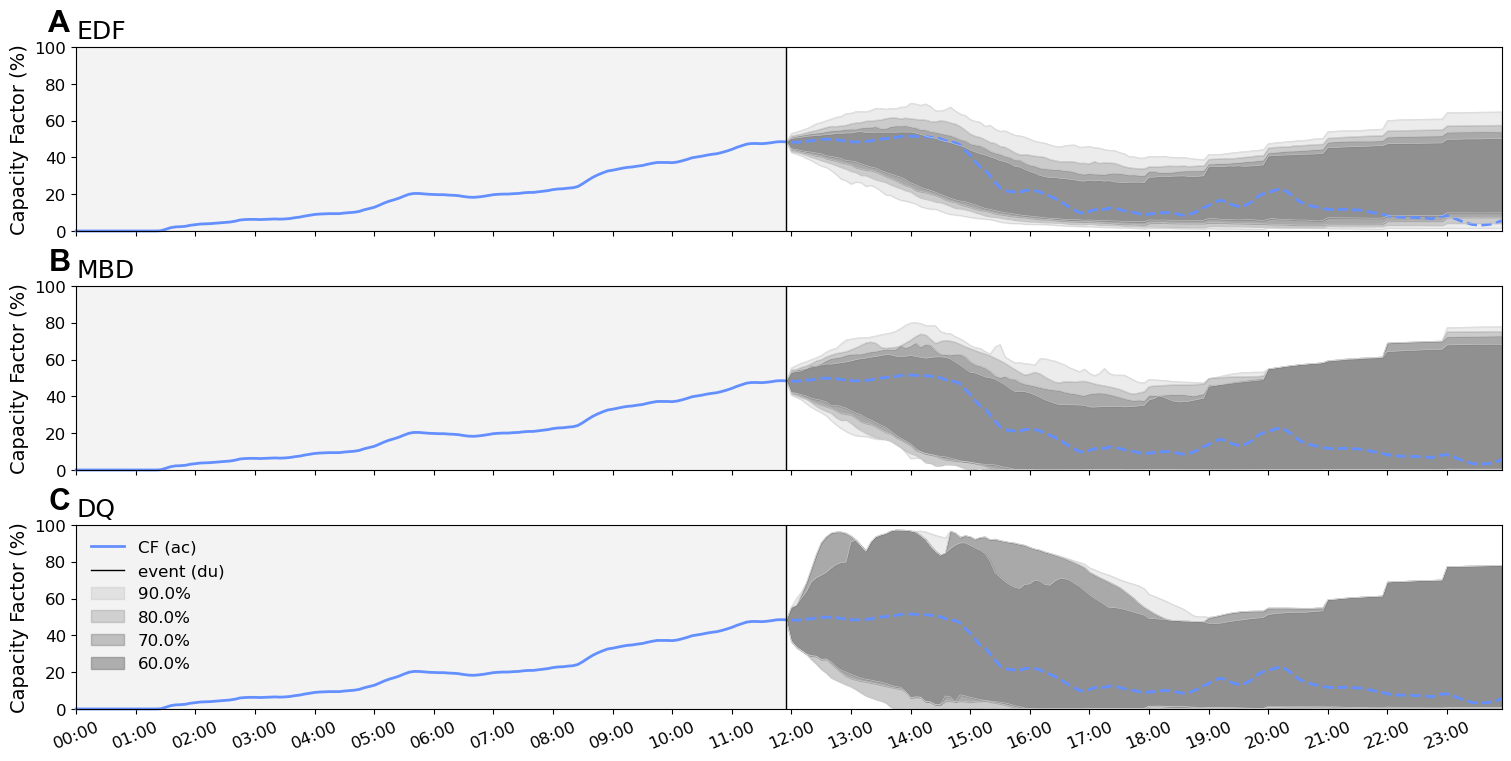

In [ ]:
alpha_ = [0.1, 0.2, 0.3, 0.4]

_fig, _ax = plt.subplot_mosaic([["A"], ["B"], ["C"]],
                               figsize = (15, 7.5),
                               layout  = "constrained", 
                               sharex  = True)
    
for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, _fig.dpi_scale_trans)),
            fontsize  = 22, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')
    
# Calculate confidence intervals from functional depth metrics
m_, _upper, _lower = _confidence_intervals_from_eCDF(M_, alpha_)

_plot_envelop(_ax["A"], 
              palette_, 
              _upper, 
              _lower, 
              f_, 
              f_hat_, 
              dt_, 
              dx_, 
              tau_, 
              s_, 
              time, 
              legend = False)

_ax["A"].set_title('EDF', fontsize = 18, loc = 'left')

# Calculate confidence intervals from Directional Quantiles
m_, _upper, _lower = _confidence_intervals_from_DQ(M_, alpha_)

_plot_envelop(_ax["B"], 
              palette_, 
              _upper, 
              _lower, 
              f_, 
              f_hat_, 
              dt_, 
              dx_, 
              tau_, 
              s_, 
              time, 
              legend = False)

_ax["B"].set_title('MBD', fontsize = 18, loc = 'left')

# Calculate confidence intervals from the functional depth metric
m_, _upper, _lower = _confidence_intervals_from_depth(M_, alpha_)

_plot_envelop(_ax["C"], 
              palette_, 
              _upper, 
              _lower, 
              f_, 
              f_hat_, 
              dt_, 
              dx_, 
              tau_, 
              s_, 
              time, 
              legend = True)

_ax["C"].set_title('DQ', 
                   fontsize = 18, loc = 'left')

plt.savefig(path_to_images + r"/functional_envelop.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()